# 0.0 Imports

In [26]:
# Data Manipulation
import numpy as np
import pandas as pd

# Data Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# ignore warnings from the kernel
import warnings
warnings.filterwarnings( 'ignore' )


# Feature Selection
from boruta import BorutaPy
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier


# Machine Learning Moddeling
from sklearn.linear_model import LogisticRegression, Lasso
from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.svm import SVC
import xgboost as xgb

# ML Metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score, roc_auc_score, plot_confusion_matrix, roc_curve



# 1.0 Load Data


In [4]:
dscombined = pd.read_csv( 'C:/Users/PICHAU/Desktop/AIbox-Feedback/AIBOX-Mlfeedback/datasets/combined.csv' )
dsLIWC = pd.read_csv( 'C:/Users/PICHAU/Desktop/AIbox-Feedback/AIBOX-Mlfeedback/datasets/combinedLIWC.csv' )
dsCohmetrix = pd.read_csv( 'C:/Users/PICHAU/Desktop/AIbox-Feedback/AIBOX-Mlfeedback/datasets/combined_CohMetrix.csv' )


# 2.0 Merging data

In [5]:
dsCohmetrix = dsCohmetrix.rename( columns={ 'ID':'id' } )

In [6]:
mergedData = pd.merge(dsCohmetrix, dsLIWC, how='left', on='id')
mergedData = pd.merge(mergedData, dscombined, how='left', on='id')
# df1.merge(df2, how='inner', on='a')

In [7]:
mergedData

id  cm.DESPC  cm.DESSC  cm.DESWC  cm.DESPL  cm.DESPLd   cm.DESSL  \
0       23         1         1        18       1.0        0.0  17.000000   
1       24         1         2        24       2.0        0.0  10.500000   
2       35         1         2        31       2.0        0.0  12.500000   
3       37         1         1         7       1.0        0.0   6.000000   
4       68         1         4        32       4.0        0.0   6.500000   
..     ...       ...       ...       ...       ...        ...        ...   
995  13809         1         2        28       2.0        0.0  12.000000   
996  13810         1         2        66       2.0        0.0  29.500000   
997  13811         1         2        37       2.0        0.0  16.500000   
998  13813         1         3        28       3.0        0.0   7.666667   
999  13814         1         3        28       3.0        0.0   7.666667   

     cm.DESSLd  cm.DESWLsy  cm.DESWLsyd  ...  liwc.leisure  liwc.home  \
0     0.000000    1.888889     0.900254  ...             1          0   
1     0.500000    1.916667     1.100066  ...             1          0   
2     0.500000    1.741935     0.964978  ...             2          0   
3     0.000000    1.857143     1.069045  ...             0          0   
4     3.640055    1.937500     1.268413  ...             0          0   
..         ...         ...          ...  ...           ...        ...   
995  11.000000    2.250000     1.404358  ...             0          0   
996  27.500000    1.969697     1.149845  ...             2          0   
997  15.500000    2.027027     1.213042  ...             2          2   
998  10.143416    1.964286     1.170063  ...             2          0   
999  10.143416    2.000000     1.217161  ...             2          0   

     liwc.money  liwc.relig  liwc.death  liwc.assent  liwc.nonfl  liwc.filler  \
0             0           0           0            0           0            0   
1             1           0           0            0           0            0   
2             0           0           0            0           0            0   
3             0           0           0            0           0            0   
4             1           0           0            2           0            0   
..          ...         ...         ...          ...         ...          ...   
995           1           0           0            0           1            0   
996           1           0           0            1           0            0   
997           0           0           0            1           2            0   
998           0           1           0            0           1            0   
999           0           1           0            0           1            0   

                                              feedback  classe  
0    Ler outros textos sobre o assunto para lher da...       0  
1    Procure ler mais; para escrever mais acerca do...       0  
2    Texto bom; precisa apenas ler mais um pouco; p...       0  
3                  Ter cuidado com copias da internet.       0  
4    Carssimo; o trabalho precisa de uma sistematiz...       1  
..                                                 ...     ...  
995  Rosivalda; timo texto; suas reflexes comparati...       1  
996  Ruth; bom texto sobre o filme e sobre as suas ...       1  
997  Silmara; excelente texto e leitura do filme co...       1  
998  Sueli; boa leitura do filme e da realidade; su...       1  
999  Taciana; boa leitura do filme e da realidade; ...       1  

[1000 rows x 161 columns]

## 2.1 Check Nan

In [8]:
mergedData.isna().sum().sort_values()


id                0
liwc.ipron        0
liwc.article      0
liwc.verb         0
liwc.auxverb      0
               ... 
cm.RDL2         165
cm.CRFCWO1      165
cm.CRFCWO1d     165
cm.LSASSpd      362
cm.LSASSp       362
Length: 161, dtype: int64

## 2.2 Fillout NAn

In [9]:
mergedData = mergedData.dropna(axis=1, how='any', inplace=False) # axis=1 => columns

In [10]:
mergedData.isna().sum().sort_values()

id              0
liwc.article    0
liwc.verb       0
liwc.auxverb    0
liwc.past       0
               ..
cm.SMCAUSr      0
cm.SMCAUSlsa    0
cm.SMCAUSwn     0
cm.CNCComp      0
classe          0
Length: 155, dtype: int64

# 3.0 Data Preparation



## 3.1 Normalization

In [11]:
# no analyzed variable looks like a normal distribution

## 3.2 Rescaling

In [12]:
mergedData.dtypes

id               int64
cm.DESPC         int64
cm.DESSC         int64
cm.DESWC         int64
cm.DESPL       float64
                ...   
liwc.death       int64
liwc.assent      int64
liwc.nonfl       int64
liwc.filler      int64
classe           int64
Length: 155, dtype: object

In [13]:
visu = mergedData.select_dtypes( exclude=['int64', 'float64','int32','UInt32'] )
print(visu)

Empty DataFrame
Columns: []
Index: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, ...]

[1000 rows x 0 columns]


In [14]:
# thus, due to feedback be a no-analyzed variable, merged dataset doesn't need rescaling
# so, the other variables doesnt need a changes, for now, because the outliers problem will be solved on cohmetrix software  

## 3.3 Transformation


In [15]:
# once time again, transformation is not necessary, due to mergedData only have feedback that is a categorical variable and the response variable is only 0 and 1

# 4.0 EDA - Correlation of numAtttributes

In [16]:
num_attributes = mergedData.select_dtypes( include=['int64', 'float64'] )

# 5.0 Feature Selection


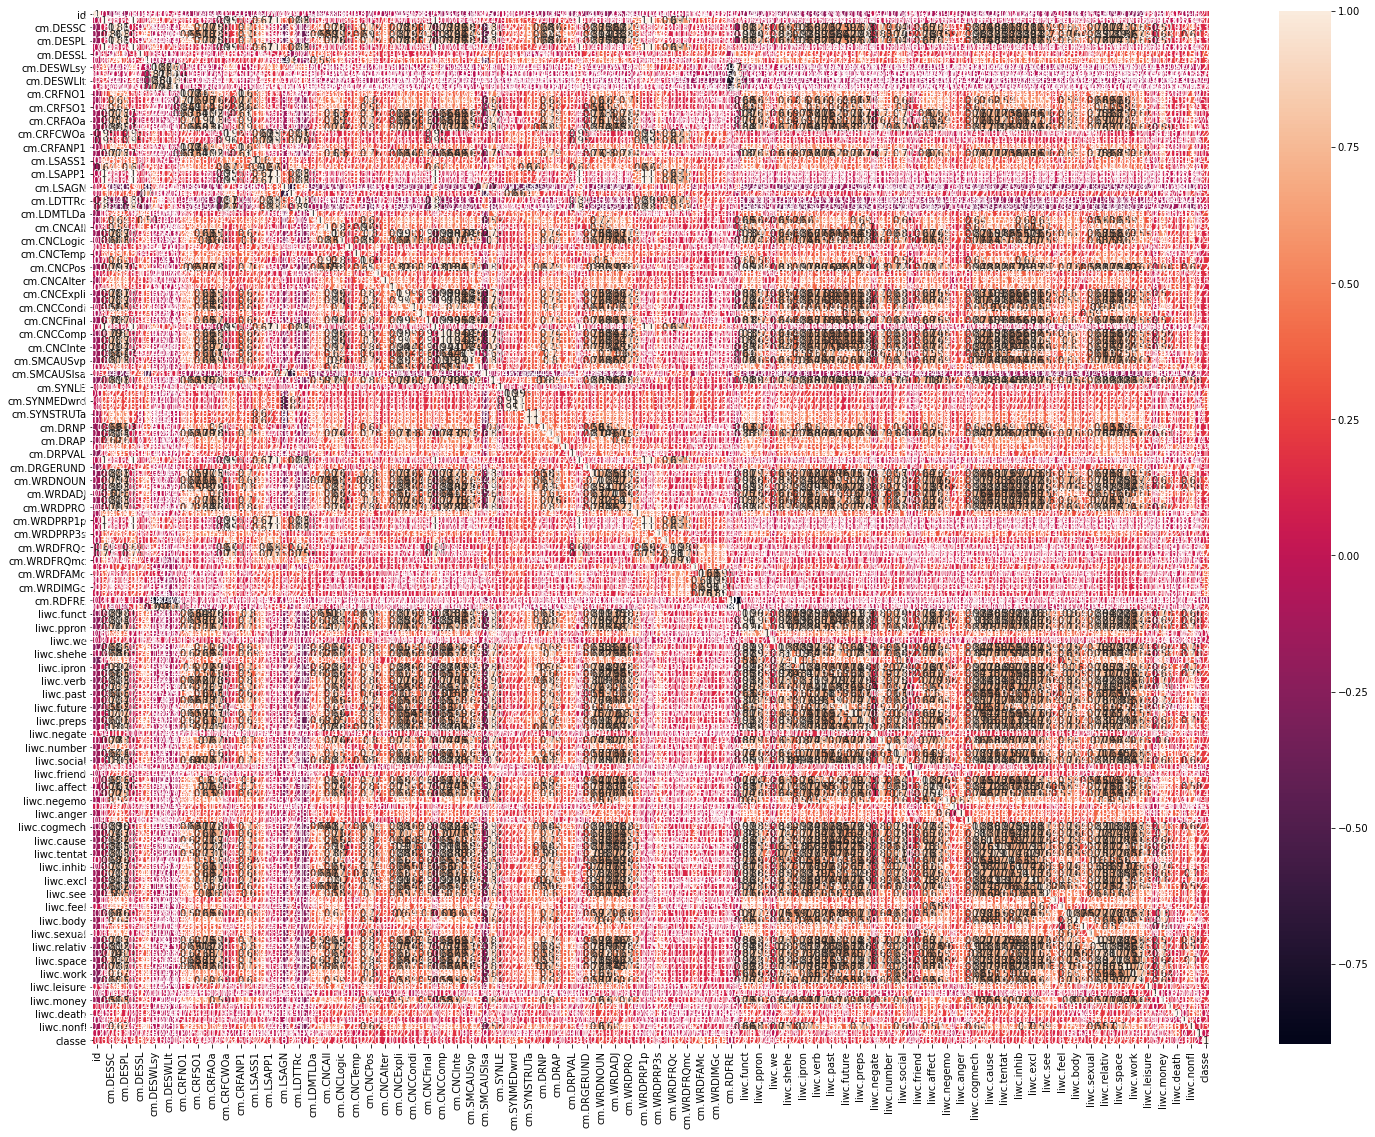

In [17]:
correlation = num_attributes.corr( method='pearson' )
plt.figure( figsize=( 25, 19 ) )
sns.heatmap( correlation, annot=True );

## 4.1 Split dataframe into training and test dataset

In [18]:
# training dataset
X_train = mergedData[mergedData['id']<12800] # this id split dataset in 3/4 proportion
y_train = X_train['classe']

# test dataset 
X_test = mergedData[mergedData['id']>=12800] # this id split dataset in 3/4 proportion
y_test = X_test['classe']


In [19]:
X_train

id  cm.DESPC  cm.DESSC  cm.DESWC  cm.DESPL  cm.DESPLd   cm.DESSL  \
0       23         1         1        18       1.0        0.0  17.000000   
1       24         1         2        24       2.0        0.0  10.500000   
2       35         1         2        31       2.0        0.0  12.500000   
3       37         1         1         7       1.0        0.0   6.000000   
4       68         1         4        32       4.0        0.0   6.500000   
..     ...       ...       ...       ...       ...        ...        ...   
756  12769        -1        -1        -1      -1.0       -1.0  -1.000000   
757  12773         1         3        25       3.0        0.0   6.333333   
758  12788         1         2        13       2.0        0.0   5.500000   
759  12790         1         1        49       1.0        0.0  45.000000   
760  12796         1         2        20       2.0        0.0   7.500000   

     cm.DESSLd  cm.DESWLsy  cm.DESWLsyd  ...  liwc.achieve  liwc.leisure  \
0     0.000000    1.888889     0.900254  ...             0             1   
1     0.500000    1.916667     1.100066  ...             1             1   
2     0.500000    1.741935     0.964978  ...             4             2   
3     0.000000    1.857143     1.069045  ...             0             0   
4     3.640055    1.937500     1.268413  ...             2             0   
..         ...         ...          ...  ...           ...           ...   
756  -1.000000   -1.000000    -1.000000  ...             0             0   
757   5.557777    2.120000     1.394035  ...             1             0   
758   4.500000    2.230769     1.832750  ...             0             0   
759   0.000000    1.938776     1.375502  ...             1             2   
760   5.500000    2.050000     1.316894  ...             1             0   

     liwc.home  liwc.money  liwc.relig  liwc.death  liwc.assent  liwc.nonfl  \
0            0           0           0           0            0           0   
1            0           1           0           0            0           0   
2            0           0           0           0            0           0   
3            0           0           0           0            0           0   
4            0           1           0           0            2           0   
..         ...         ...         ...         ...          ...         ...   
756          0           0           0           0            0           0   
757          0           0           0           0            0           1   
758          0           0           0           0            0           0   
759          0           2           0           0            0           1   
760          0           0           0           0            0           1   

     liwc.filler  classe  
0              0       0  
1              0       0  
2              0       0  
3              0       0  
4              0       1  
..           ...     ...  
756            0       0  
757            0       1  
758            0       1  
759            0       1  
760            0       1  

[751 rows x 155 columns]

## 4.2 Boruta as Feature Selector

In [20]:
# training and test dataset for Boruta
X_train_n = X_train.drop( ['classe'], axis=1 ).values 
y_train_n = y_train.values.ravel() 

# define RandomForestRegressor
rf = RandomForestClassifier( random_state=42 )

# define Boruta
boruta = BorutaPy( rf, n_estimators='auto', verbose=2, random_state=42 ).fit( X_train_n, y_train_n )


Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	154
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	154
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	154
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	154
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	154
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	154
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	154
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	24
Tentative: 	10
Rejected: 	120
Iteration: 	9 / 100
Confirmed: 	24
Tentative: 	10
Rejected: 	120
Iteration: 	10 / 100
Confirmed: 	24
Tentative: 	10
Rejected: 	120
Iteration: 	11 / 100
Confirmed: 	24
Tentative: 	10
Rejected: 	120
Iteration: 	12 / 100
Confirmed: 	24
Tentative: 	7
Rejected: 	123
Iteration: 	13 / 100
Confirmed: 	24
Tentative: 	7
Rejected: 	123
Iteration: 	14 / 100
Confirmed: 	24
Tentative: 	7
Rejected: 	123
Iteration: 	15 / 100
Confirmed: 	24
Tentative: 	7
Rejected: 	123
Iteration: 	16 / 100
Confirmed: 	24
T

### 4.2.1 Best features Boruta

In [21]:
cols_selected = boruta.support_.tolist() # devolve o valor do rank baseado na relevancia

# best features 
X_train_fs = X_train.drop( ['classe'], axis=1 ) # axis=1 dropar as colunas inteiras
cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.to_list()

# # not selected boruta 
cols_not_selected_boruta = np.setdiff1d

In [22]:
del cols_selected_boruta[0] # removing 'id' from cols_selected_boruta 


In [23]:
cols_selected_boruta


['cm.DESWC',
 'cm.DESSL',
 'cm.DESWLsy',
 'cm.DESWLltd',
 'cm.SMCAUSlsa',
 'cm.SMCAUSwn',
 'cm.WRDNOUN',
 'cm.WRDVERB',
 'cm.WRDFRQc',
 'cm.WRDFRQa',
 'cm.WRDFRQmc',
 'cm.WRDFAMc',
 'cm.WRDCNCc',
 'cm.WRDIMGc',
 'cm.WRDMEAc',
 'cm.RDFRE',
 'cm.RDFKGL',
 'liwc.funct',
 'liwc.preps',
 'liwc.social',
 'liwc.cogmech',
 'liwc.relativ',
 'liwc.space']

# 6.0 Machine Learning Modelling

##  6.1. Stochastic Gradient Descent Classifier (SGDClassifier)

In [41]:
#  # Train SGDClassifier
# sgdc = SGDClassifier(random_state=42)
# sgdc.fit(X_train, y_train)

# # Predict
# sgdc_yhat = sgdc.predict(X_test)

# # ROC-AUC
# sgdc_cv = cross_val_predict(sgdc, X_train, y_train, cv=5, method='decision_function')
# sgd_roc_auc = roc_auc_score(y_train, sgdc_cv)

# # performance
# sgdc_performance = pd.DataFrame(['SGDClassifier',
#                                     accuracy_score(y_test, sgdc_yhat),
#                                     precision_score(y_test, sgdc_yhat),
#                                     recall_score(y_test, sgdc_yhat),
#                                     f1_score(y_test, sgdc_yhat),
#                                     sgd_roc_auc]).T
# sgdc_performance.columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']


# sgdc_performance

NameError: name 'SGDClassifier' is not defined

## 6.2 Logistic Regression

In [28]:
# Train Logistic Regression Model
logreg = LogisticRegression(random_state=42)
logreg.fit(X_train, y_train)

# Predict
logreg_yhat = logreg.predict(X_test)

# ROC-AUC
logreg_cv = cross_val_predict(logreg, X_train, y_train, cv=5, method='decision_function')
logreg_roc_auc = roc_auc_score(y_train, logreg_cv)

# performance
logreg_performance = pd.DataFrame(['Logistic Regression',
                                    accuracy_score(y_test, logreg_yhat),
                                    precision_score(y_test, logreg_yhat),
                                    recall_score(y_test, logreg_yhat),
                                    f1_score(y_test, logreg_yhat)).T
logreg_performance.columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score']


logreg_performance

Model  Accuracy Precision    Recall  F1-Score   ROC-AUC
0  Logistic Regression  0.947791  0.954733  0.991453  0.972746  0.870892

## 6.3 Random Forest Classifier

In [42]:
 # Train Random Forest
randforest = RandomForestClassifier(random_state=42, n_jobs=-1)
randforest.fit(X_train, y_train)

# Predict
randforest_yhat = randforest.predict(X_test)

# performance
randforest_performance = pd.DataFrame(['Random Forest Classifier',
                                    accuracy_score(y_test, randforest_yhat),
                                    precision_score(y_test, randforest_yhat),
                                    recall_score(y_test, randforest_yhat),
                                    f1_score(y_test, randforest_yhat)]).T
randforest_performance.columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score']


randforest_performance

Model  Accuracy Precision    Recall  F1-Score
0  Random Forest Classifier  0.991968  0.995726  0.995726  0.995726

## 6.4 Support Vector Machine Classifier

In [43]:
# Training SVM
svm = SVC(random_state=42)
svm.fit(X_train, y_train)

# Predict
svm_yhat = svm.predict(X_test)

# performance
svm_performance = pd.DataFrame( ['SVM Classifier',
                                    accuracy_score(y_test, svm_yhat),
                                    precision_score(y_test, svm_yhat),
                                    recall_score(y_test, svm_yhat),
                                    f1_score(y_test, svm_yhat) ] ).T
svm_performance.columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score']


svm_performance

Model  Accuracy Precision Recall  F1-Score
0  SVM Classifier  0.939759  0.939759    1.0  0.968944

## 6.5 XGB Classifier

In [44]:
 # Train Random Forest
xgboost = xgb.XGBClassifier(random_state=42, eval_metric='error')
xgboost.fit(X_train, y_train);

# Predict
xgboost_yhat = xgboost.predict(X_test);

# performance
xgboost_performance = pd.DataFrame(['XGBooster Classifier',
                                    accuracy_score(y_test, xgboost_yhat),
                                    precision_score(y_test, xgboost_yhat),
                                    recall_score(y_test, xgboost_yhat),
                                    f1_score(y_test, xgboost_yhat),
                                   ]).T
xgboost_performance.columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score']

xgboost_performance

Model Accuracy Precision Recall F1-Score
0  XGBooster Classifier      1.0       1.0    1.0      1.0

## 6.6 Cross-validation of all models

In [38]:
# Merging train and test dataset to make the Cross-Validation
x_full = pd.concat([X_train, X_test])
y_full = pd.concat([y_train, y_test])

In [51]:
# Accuracy of randforest
randforest_cv = cross_val_score(randforest, x_full, y_full, cv=10, scoring='accuracy')
randforest_cv_acc = pd.DataFrame(['Randforest', (randforest_cv.mean() * 100).round(3),(randforest_cv.std() * 100).round(3)]).T

# # Accuracy of sdgc
# sgdc_cv = cross_val_score(sgdc, x_full, y_full, cv=10, scoring='accuracy')
# sgdc_cv_acc = pd.DataFrame(['Sdgc', (sgdc_cv.mean() * 100).round(3),(sgdc_cv.std() * 100).round(3)]).T

# Accuracy of logistic Regression
logreg_cv = cross_val_score(logreg, x_full, y_full, cv=10, scoring='accuracy')
logreg_cv_acc = pd.DataFrame(['logistic Reg', (logreg_cv.mean() * 100).round(3),(logreg_cv.std() * 100).round(3)]).T

# Accuracy of SVM Model
svm_cv = cross_val_score(svm, x_full, y_full, cv=10, scoring='accuracy')
svm_cv_acc = pd.DataFrame(['SVM classifier', (svm_cv.mean() * 100).round(3),(svm_cv.std() * 100).round(3)]).T

# Accuracy of XGBoost Classifier
xgboost_cv = cross_val_score(xgboost, x_full, y_full, cv=10, scoring='accuracy')
xgboost_cv_acc = pd.DataFrame(['XGBoost Classifier', (xgboost_cv.mean() * 100).round(3),(xgboost_cv.std() * 100).round(3)]).T



General_cv= pd.concat([randforest_cv_acc, logreg_cv_acc, svm_cv_acc, xgboost_cv_acc])

General_cv.columns = ['Model', 'Mean', 'std']
General_cv

Model   Mean    std
0          Randforest   98.9    1.3
0        logistic Reg   89.4  2.375
0      SVM classifier   89.0    0.0
0  XGBoost Classifier  100.0    0.0